# In this notebook we will present all the results and then choose

\begin{itemize}
    \item Pure data analysis section. where we check curvature i guess. (Anything else?) We could look at a histogram of points in 1D, but how useful would that be?
    \item Section with a table. 
    \item Section 2D visulization. Also 1D visulization. These should be modifiable that i just give it some data and then it's presented. This is because i could just    span some subspace in any dimension and then look how well it interpolates. 
\end{itemize}

In [1]:
import sys, os
import ujson as json
from pathlib import Path 
HOME = "/rds/general/user/dl2119/home/ICLR_Interp" # Path(os.environ["PATH_INTP_FOLDER"])
os.environ["PATH_INTP_FOLDER"] = HOME
HOME = Path(HOME)
sys.path.append(str(HOME))
sys.path.append(str(HOME / "DataGeneration"))
sys.path.append(str(HOME / "ModelGeneration"))
sys.path.append(str(HOME / "ModelComparison"))


import pandas as pd 
import jax.random as jrandom
from scipy.interpolate import RBFInterpolator
import jax.numpy as jnp
import numpy as np

from GModel import GModel
from ModelComparison import get_rbf_tags
from save_load_data import load_fast, get_all_data_configurations
from save_load_model import save_nn, get_all_net_tags
from save_load_comps import load_all_comps
from nn_train import train
from DataAnalysis import curv

from vis_utils import get_line_along_v, get_constrained_plane_along_uv




import torch
import torchvision
import torch.optim as optim
from torch import Tensor

import torch.nn as nn
from torch.nn import Module

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 

from Functions import get_func
import numpy as np

%load_ext autoreload
%autoreload 2

# Data Visualization

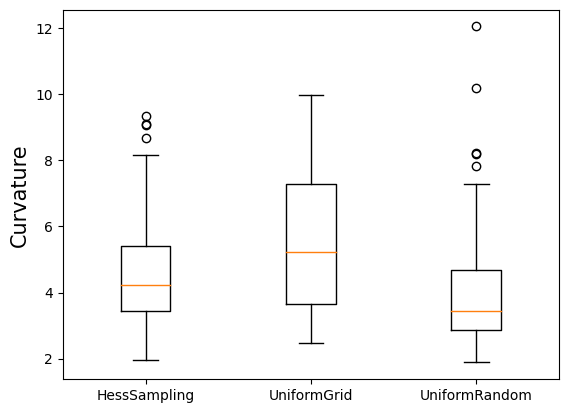

In [41]:
def compute_hess_trace_stat(func, dim, N):
    res = {}
    for data_gen_method in ["HessSampling", "UniformGrid", "UniformRandom"]:
        X_data, y_data = load_fast(func, dim, N, data_gen_method)
        F = get_func(func)
        res[data_gen_method] = np.array(curv(F, X_data))

    fig, ax = plt.subplots()
    ax.boxplot(res.values())
    ax.set_ylabel('Curvature', fontsize=15)
    ax.set_xticklabels(res.keys())
    plt.show()
    
func = "Ackley"
dim = 4
N = 100
compute_hess_trace_stat(func, dim, N)

In [22]:
from DataAnalysis import curv    
import plotly.graph_objects as go

def compute_hess_trace_stat(func, dim, N):
    for data_gen_method in ["HessSampling", "UniformGrid", "UniformRandom"]:
        X_data, y_data = load_fast(func, dim, N, data_gen_method)
        F = get_func(func)
        curv_vals = np.array(curv(F, X_data))
        plt.boxplot(curv_vals)
        
    plt.show()
    

    
# For each data, I want to visualize the curvature hist. 
# For each data, I want to visualize 1 and 2D locations. Option toggle to overlay the real data with lower opacity
def hess_trace_visualization(func, dim, N, data_gen_method):
    X_data, y_data = load_fast(func, dim, N, data_gen_method)
    F = get_func(func)
    curv_vals = np.array(curv(F, X_data))
    plt.hist(curv_vals)
    
    plt.show()
    
def loc_vis(func, dim, N, data_gen_method, N_vis):
    assert dim <= 2
    
#     X_data, y_data = load_fast(func, dim, N, data_gen_method)
    F = get_func(func)
    
    if dim == 1:
        x_vis = np.linspace(F.bounds[0][0], F.bounds[0][1], N_vis).reshape(-1, 1)
        F_vis = F.f(x_vis)
        hess_trace_vis = curv(F, x_vis)
        
        hess_trace_data = curv(F, X_data)
        
        # F vis
        plt.plot(x_vis, F_vis)
        plt.scatter(X_data, y_data)
        plt.show()
        
        # Hess vis
        plt.plot(x_vis, hess_trace_vis)
        plt.scatter(X_data, hess_trace_data)
        plt.show()
        
    else:
        x_vis = np.linspace(F.bounds[0][0], F.bounds[0][1], N_vis).reshape(-1, 1)
        XY = np.meshgrid(x_vis, x_vis)
        pts = np.array([XY[0].ravel(), XY[1].ravel()]).T
        
        F_vis = F.f(pts)
        hess_trace_vis = curv(F, pts)
#         hess_trace_data = curv(F, X_data)
        
        # F vis
        fig = go.Figure(data=[go.Mesh3d(x = pts[:, 0], y = pts[:, 1], z = F_vis, opacity=1),
                                #go.Scatter3d(x=X_data[:, 0], y=X_data[:, 1], z=y_data, mode='markers')
        ])
        fig.update_layout(scene = dict(
                    xaxis_title='x',
                    yaxis_title='y',
                    zaxis_title='Function value'))
        camera = dict(
        eye=dict(x=2, y=2, z=0.1)
        )

        fig.update_layout(scene_camera=camera, width =1000, height=1000)
        fig.show()
        
        # Hess vis
        #fig = go.Figure(data=[go.Mesh3d(x = pts[:, 0], y = pts[:, 1], z = hess_trace_vis, opacity = 0.5),
        #                        go.Scatter3d(x=X_data[:, 0], y=X_data[:, 1], z=hess_trace_data, mode='markers')
        #])
#         fig = go.Figure(data=[go.Contour(x = pts[:, 0], y = pts[:, 1], z = hess_trace_vis, \
#                                          colorscale='gnbu', contours_coloring='heatmap', \
#                                          line_width=0), go.Scatter(x=X_data[:, 0], y=X_data[:, 1], mode='markers', \
#                                         marker=dict(color='LavenderBlush',size=10,line=dict(width=1,
#                                         color='DarkSlateGrey')))\
#                                          ])
#         fig.update_layout(width=500)
#         fig.show()
        
        
        


        
func = "Dixon"
dim = 2
N = 100
data_gen_method = "UniformGrid"
N_vis = 100
loc_vis(func, dim, N, data_gen_method, N_vis)
# loc_vis(func, dim, N, "HessSampling", N_vis)




In [13]:
func = "Michi"
dim = 3
N = 100
data_gen_method = "HessSampling"

hess_trace_visualization(func, dim, N, data_gen_method)
hess_trace_visualization(func, dim, N, "UniformRandom")

AttributeError: 'NoneType' object has no attribute 'shape'

# Trained Model Visualization

In [49]:
from torch import Tensor
from chart_studio import plotly as py
import plotly.graph_objs as go

def visualize_1d(func_name, dim, N, data_gen_method, model_tag, v, N_param):
    model = GModel(func_name, dim, N, data_gen_method, tag)
    F = get_func(func_name)
    vs = get_line_along_v(F, v, N_param)
    z_model = model.f(vs)
    z_true = F.f(vs)
    plt.plot(jnp.linspace(-1, 1, N_param), z_model, label="model")
    plt.plot(jnp.linspace(-1, 1, N_param), z_true, label="true")
    plt.legend()
    plt.show()
    
def visualize_2d(func_name, dim, N, data_gen_method, model_tag, u, v, N_param):
    model = GModel(func_name, dim, N, data_gen_method, tag)
    F = get_func(func_name)
    prmtrztn, pts = get_constrained_plane_along_uv(F, u, v, N_param)    
    
    z_model = model.f(pts)
    z_true = F.f(pts)
    
    
    fig = go.Figure(data=[go.Mesh3d(x = prmtrztn[0], y = prmtrztn[1], z = z_model, opacity=0.7, name="model"),
                         go.Mesh3d(x = prmtrztn[0], y = prmtrztn[1], z = z_true, opacity=0.2, name="true")])
    
#     fig.update_layout(showlegend=True)
    fig.show()
    

In [155]:

func_name = "Michi"
dim = 2
N = 1000
data_gen_method = "UniformRandom"
# tag = "nn_depth_4_width_8_opt_Adam_lr_0.001_bs_16_l2p_0" # get_all_net_tags(func_name, dim, N, data_gen_method)[0]

tag = "rbf_{}_neighbors_1000.0".format("thin_plate_spline")

# SEE HERE FOR WHICH TAGS ARE AVAILABLE
available_nn_tags = get_all_net_tags(func_name, dim, N, data_gen_method)
available_rbf_tags = get_rbf_tags()
# tag = available_rbf_tags[0]
print(tag)

N_param = 100
v = np.random.normal(size=(dim))
v /= np.linalg.norm(v)
u = np.random.normal(size=(dim))
u /= np.linalg.norm(u)

rbf_thin_plate_spline_neighbors_1000.0


In [132]:
50**4

6250000

(100, 2)


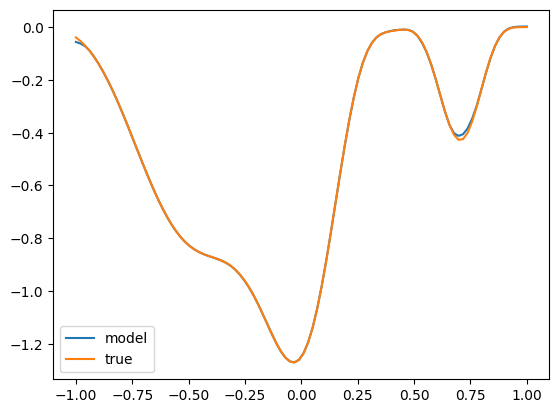

In [156]:

visualize_1d(func_name, dim, N, data_gen_method, tag, v, N_param)

visualize_2d(func_name, dim, N, data_gen_method, tag, u, v, N_param)

(50, 1)


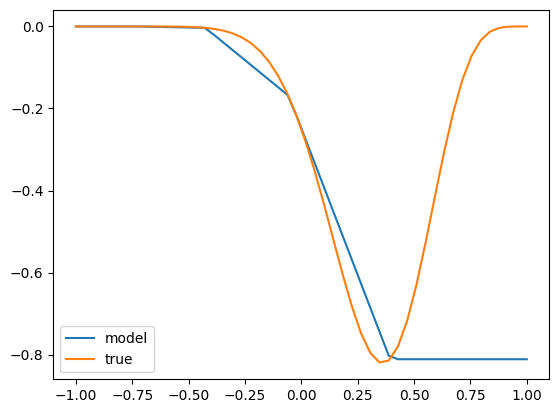

In [94]:

visualize_1d(func_name, dim, N, "HessSampling", tag, v, N_param)

# visualize_2d(func_name, dim, N, data_gen_method, tag, u, v, N_param)

# Trained Model Comps

In [84]:
df = load_all_comps()

In [ ]:
group by stuff

In [85]:
subset_df = df.groupby(by=["func_name", "dim", "N", "model", "kernel", "data_gen_method"]).apply(lambda x: x["testLoss"].min())


In [98]:
subset_df["Michi"][100:150]

dim  N       model  kernel    data_gen_method
2    10000   rbf    gaussian  UniformGrid        1.400487e-12
                              UniformRandom      1.528675e-13
                    linear    HessSampling       3.849036e-04
                              UniformGrid        1.516751e-08
                              UniformRandom      4.443771e-07
                    thin      HessSampling       1.894485e-04
                              UniformGrid        1.382716e-09
                              UniformRandom      1.874097e-08
     100000  nn     0         HessSampling       7.406549e-04
                              UniformGrid        1.616861e-05
                              UniformRandom      1.342576e-05
             rbf    gaussian  HessSampling       9.405255e-05
                              UniformGrid        7.252587e-12
                              UniformRandom      4.903805e-11
                    linear    HessSampling       7.842260e-03
                        

In [100]:
subset_df = df.groupby(by=["func_name", "dim", "N", "data_gen_method"]).apply(lambda x: x["testLoss"].min())
subset_df

func_name   dim  N       data_gen_method
Ackley      1    10      HessSampling       1.183131e+01
                         UniformGrid        3.662521e+00
                         UniformRandom      1.344672e+00
                 100     HessSampling       7.409828e-01
                         UniformGrid        7.065569e-01
                                                ...     
Rosenbrock  6    10000   UniformGrid        2.492749e+09
                         UniformRandom      1.266440e+08
                 100000  HessSampling       1.622072e+08
                         UniformGrid        2.350573e+08
                         UniformRandom      2.064470e+07
Length: 180, dtype: float64

In [165]:
subset_df = df.groupby(by=["func_name", "dim", "N"]).apply(lambda x: x["data_gen_method"].iloc[x["testLoss"].argmin()])
subset_df[subset_df.values == "HessSampling"]


func_name   dim  N    
Michi       2    10       HessSampling
            4    10       HessSampling
                 1000     HessSampling
            6    1000     HessSampling
                 10000    HessSampling
Rosenbrock  1    10       HessSampling
                 100      HessSampling
                 1000     HessSampling
                 10000    HessSampling
            4    100      HessSampling
                 1000     HessSampling
            6    1000     HessSampling
dtype: object

(array([30.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0., 14.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

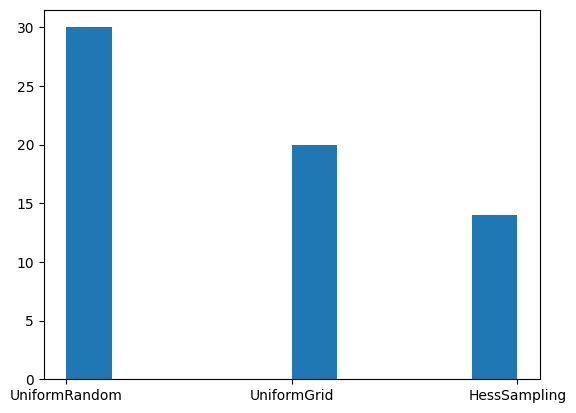

In [109]:
subset_df = df[df["model"] == "nn"].groupby(by=["func_name", "dim", "N"]).apply(lambda x: x["data_gen_method"].iloc[x["testLoss"].argmin()])
plt.hist(subset_df.values)



(array([32.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  0., 11.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

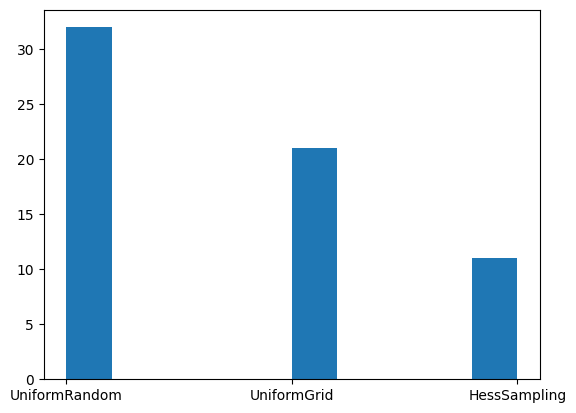

In [110]:
subset_df = df[df["model"] == "rbf"].groupby(by=["func_name", "dim", "N"]).apply(lambda x: x["data_gen_method"].iloc[x["testLoss"].argmin()])
plt.hist(subset_df.values)




In [67]:
import jax.random as jrandom

N_test = int(1e3)
seed_test = 1
jrandom_key = jrandom.PRNGKey(seed_test)

In [78]:

func_name = "Rosenbrock"
dim = 6
N = 1000
data_gen_method = "UniformRandom"

F = get_func(func_name)
X_test = np.array(jrandom.uniform(jrandom_key, minval=F.bounds[:, 0], maxval=F.bounds[:, 1],shape=(N_test, dim)))
y_test = np.array(F.f(X_test))
X_train, y_train = load_fast(func_name, dim, N, data_gen_method)

In [79]:

def compute_loss(model, X_train, y_train, X_test, y_test):

    test_out = model.f(X_test)
    test_errs = (y_test - test_out)**2
    test_mean_err = np.mean(test_errs)

    res = {"test_mean_err": float(test_mean_err) } #, "test_errs": test_errs.tolist(), }

    if model.tag_dict['model'] == "nn":
        train_out = model.f(X_train)
        train_errs = (y_train - train_out)**2
        train_mean_err = np.mean(train_errs)
        res["train_errs"] = train_errs.tolist()
        res["train_mean_err"] = float(train_mean_err)

    return res

def rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test): 
    res = {}

#     for rbf_tag in get_rbf_tags():
    rbf_tag = 'rbf_linear_neighbors_1000.0'
    rbf_model = GModel(func_name, dim, N, data_gen_method, rbf_tag)
    res[rbf_tag] = compute_loss(rbf_model, X_train, y_train, X_test, y_test)
    return res

In [80]:
rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test)

{'rbf_linear_neighbors_1000.0': {'test_mean_err': 7914421868.951873}}

In [81]:
data_gen_method = "UniformGrid"

rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test)

{'rbf_linear_neighbors_1000.0': {'test_mean_err': 26944094813.334484}}

In [82]:
data_gen_method = "HessSampling"

rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test)

{'rbf_linear_neighbors_1000.0': {'test_mean_err': 20303495889.543594}}

In [ ]:
thin      HessSampling       2.046637e-04
          UniformGrid        2.046637e-04
          UniformRandom      2.046637e-04